<a href="https://colab.research.google.com/github/kristacourtaway/Bitcoin-Data-Analysis/blob/main/Delivery_App_Ratings_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import re
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams, trigrams
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
df = pd.read_csv('C:/Users/15127/Desktop/Portfolio/Delivery_App_Ratings_Predictions/Food_Delivery.csv')

In [ ]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [ ]:
df.columns


Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [ ]:
[feature for feature in df.columns if df[feature].isnull().sum()>0]

['rate',
 'phone',
 'location',
 'rest_type',
 'dish_liked',
 'cuisines',
 'approx_cost(for two people)']

In [ ]:
feature_na = []
for feature in df.columns:
    if df[feature].isnull().sum()>0:
        feature_na.append(feature)
feature_na

['rate',
 'phone',
 'location',
 'rest_type',
 'dish_liked',
 'cuisines',
 'approx_cost(for two people)']

In [ ]:
df['rate'].isnull().sum()/len(df)*100

15.033741322969234

In [ ]:
for feature in feature_na:
    print('{} has {} % missing values'.format(feature,np.round(df[feature].isnull().sum()/len(df)*100,4)))

rate has 15.0337 % missing values
phone has 2.3358 % missing values
location has 0.0406 % missing values
rest_type has 0.4389 % missing values
dish_liked has 54.2916 % missing values
cuisines has 0.087 % missing values
approx_cost(for two people) has 0.669 % missing values


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

## Removing Duplicates From Data

In [ ]:
data = df.copy()

In [ ]:
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
len(data['name'].unique())

8792

In [ ]:
grouped = data.groupby(['name', 'address']).agg({'listed_in(type)':list})

In [ ]:
grouped

listed_in(type)
name                                         address                                                                                              
#FeelTheROLL                                 Opposite Mantri Commercio, Outer Ring Road, Dev...                               [Delivery, Delivery]
#L-81 Cafe                                   Sector 6, HSR Layout, HSR                           [Delivery, Dine-out, Delivery, Dine-out, Deliv...
#Vibes Restro                                Marasur Gate, Chandapura - Anekal Road, Near Al...                       [Buffet, Delivery, Dine-out]
#refuel                                      7, Ground Floor, RR Commercial Complex, Akshay ...                        [Cafes, Delivery, Dine-out]
'Brahmins' Thatte Idli                       19, 1st main, 2nd cross, 3rd stage, 3rd block, ...                                         [Dine-out]
...                                                                                                                                            ...
nu.tree                                      47/7 First floor, DoddaThogur Road, Near Velank...                                         [Delivery]
                                             Ground Floor-Lobby Area, Brigade IRV Centre, Na...                     [Delivery, Delivery, Delivery]
re:cess - Hilton Bangalore Embassy GolfLinks Hilton Bangalore Embassy GolfLinks, Embassy Gol...                [Dine-out, Dine-out, Pubs and bars]
repEAT Hub                                   67/4, Bhoganahalli Road, JCR Layout, Panathur, ...                               [Delivery, Dine-out]
sCoolMeal                                    197/293-3, 32nd Main, 1st Stage, BTM, Bangalore     [Delivery, Delivery, Delivery, Delivery, Deliv...

[12499 rows x 1 columns]

In [ ]:
newData = pd.merge(grouped, data, on = (['name', 'address']))

In [ ]:
newData.columns

Index(['name', 'address', 'listed_in(type)_x', 'url', 'online_order',
       'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type',
       'dish_liked', 'cuisines', 'approx_cost(for two people)', 'reviews_list',
       'menu_item', 'listed_in(type)_y', 'listed_in(city)'],
      dtype='object')

In [ ]:
newData.head()

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city)
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur
1,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4 /5,7,+91 9108342079\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Sarjapur Road
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM
3,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Dine-out,BTM
4,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,HSR


In [ ]:
newData.shape

(51717, 18)

In [ ]:
newData.drop_duplicates(subset = ['name', 'address', 'listed_in(type)_y'], inplace = True)

In [ ]:
newData.shape

(20915, 18)

In [ ]:
newData.head(20)

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city)
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM
3,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Dine-out,BTM
11,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Buffet,Electronic City
12,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Delivery,Electronic City
13,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Dine-out,Electronic City
14,#refuel,"7, Ground Floor, RR Commercial Complex, Akshay...","[Cafes, Delivery, Dine-out]",https://www.zomato.com/bangalore/refuel-banner...,Yes,No,3.7/5,37,+91 8971227222,Bannerghatta Road,Cafe,"Thick Shakes, Sandwiches, Pasta, Mocktails","Cafe, Beverages",400,"[('Rated 3.0', 'RATED\n We ordered for Schezw...","['Kit Kat Thick Shake', 'Ferrero Rocher Thick ...",Cafes,Bannerghatta Road
15,#refuel,"7, Ground Floor, RR Commercial Complex, Akshay...","[Cafes, Delivery, Dine-out]",https://www.zomato.com/bangalore/refuel-banner...,Yes,No,3.7/5,37,+91 8971227222,Bannerghatta Road,Cafe,"Thick Shakes, Sandwiches, Pasta, Mocktails","Cafe, Beverages",400,"[('Rated 3.0', 'RATED\n We ordered for Schezw...",[],Delivery,Bannerghatta Road
16,#refuel,"7, Ground Floor, RR Commercial Complex, Akshay...","[Cafes, Delivery, Dine-out]",https://www.zomato.com/bangalore/refuel-banner...,Yes,No,3.7/5,37,+91 8971227222,Bannerghatta Road,Cafe,"Thick Shakes, Sandwiches, Pasta, Mocktails","Cafe, Beverages",400,"[('Rated 3.0', 'RATED\n We ordered for Schezw...",[],Dine-out,Bannerghatta Road
17,'Brahmins' Thatte Idli,"19, 1st main, 2nd cross, 3rd stage, 3rd block,...",[Dine-out],https://www.zomato.com/bangalore/brahmins-that...,Yes,No,NaN,0,+91 9148013543\n+91 9902102665,Basaveshwara Nagar,Quick Bites,NaN,South Indian,100,[],"['Masala Dosa', 'Set Dosa', 'Shavige Bhath', '...",Dine-out,Rajajinagar


In [ ]:
newData = newData.reset_index(drop = True)

In [ ]:
newData.head()

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city)
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur
1,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Dine-out,BTM
3,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Buffet,Electronic City
4,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Delivery,Electronic City


In [ ]:
newData.dtypes

name                           object
address                        object
listed_in(type)_x              object
url                            object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)_y              object
listed_in(city)                object
dtype: object

In [ ]:
newData['rate'].unique

<bound method Series.unique of 0         3.4/5
1         3.9/5
2         3.9/5
3           NaN
4           NaN
          ...  
20910    4.1 /5
20911    4.1 /5
20912       NaN
20913       NaN
20914       NaN
Name: rate, Length: 20915, dtype: object>

In [ ]:
newData['rating'] = newData['rate'].str[:3]

In [ ]:
newData.head()

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur,3.4
1,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM,3.9
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Dine-out,BTM,3.9
3,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Buffet,Electronic City,NaN
4,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Delivery,Electronic City,NaN


In [ ]:
newData['rating'].replace('NEW', 0, inplace=True)
newData['rating'].replace('-', 0, inplace=True)

In [ ]:
newData.dtypes

name                           object
address                        object
listed_in(type)_x              object
url                            object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)_y              object
listed_in(city)                object
rating                         object
dtype: object

## Data Pre-Processing On Rate Feature

In [ ]:
newData['rating'] = pd.to_numeric(newData['rating'])

In [ ]:
newData['rating'].dtype

dtype('float64')

In [ ]:
newData['rating'].unique()

array([3.4, 3.9, nan, 3.7, 3.2, 3.5, 4.6, 4.1, 4.2, 4.3, 4. , 3.1, 3.6,
       3.3, 3. , 4.4, 4.5, 0. , 3.8, 2.7, 2.8, 2.9, 2.5, 4.9, 4.7, 4.8,
       1.8, 2.4, 2.1, 2.2, 2.6, 2.3, 2. ])

In [ ]:
newData['rating'].isnull().sum()

3383

In [ ]:
newData['rating'] = pd.cut(newData['rating'], bins = [1,3.25,4.1,5], labels = ['0', '1', '2'])

In [ ]:
newData.head()

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur,1
1,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM,1
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Dine-out,BTM,1
3,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Buffet,Electronic City,NaN
4,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('Rated 5.0', ""RATED\n Great service and don...",[],Delivery,Electronic City,NaN


<AxesSubplot:xlabel='rating', ylabel='Count'>

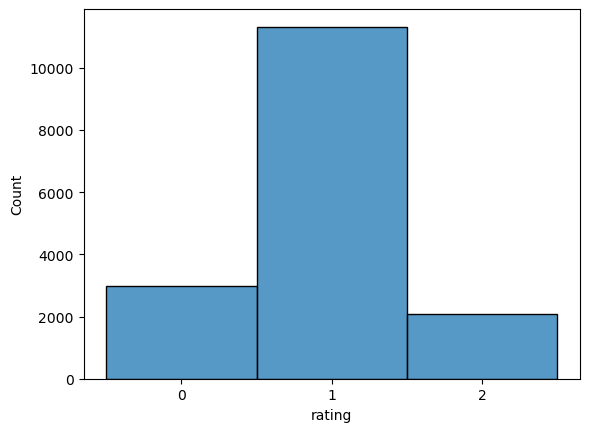

In [ ]:
sns.histplot(newData['rating'])

In [ ]:
newData['reviews_list'][0]

'[(\'Rated 5.0\', "RATED\\n  Had an egg chicken roll and a paneer roll... Really yummy... A must visit place... It would be good if you guys can keep the shop open on Sunday\'s as well.. Good luck... :-)"), (\'Rated 5.0\', \'RATED\\n  Not just the Roll but the filling tastes great. I would highly recommend to others to try their rolls. Owners hospitality is also good and very friendly.\'), (\'Rated 4.5\', \'RATED\\n  Very nice place complete value for money ? Highly recommend.Must visit for any foodie . I would recommend the egg chicken roll . #feeltheroll\'), (\'Rated 5.0\', \'RATED\\n  Had an amazing mouth-watering ?chicken roll?Worth every bite..A must try for every foodie?A variety of rolls and sandwiches are available as well .. A budding rafflesia ?\')]'

In [ ]:
rev = newData['reviews_list'][0].lower()
rev

'[(\'rated 5.0\', "rated\\n  had an egg chicken roll and a paneer roll... really yummy... a must visit place... it would be good if you guys can keep the shop open on sunday\'s as well.. good luck... :-)"), (\'rated 5.0\', \'rated\\n  not just the roll but the filling tastes great. i would highly recommend to others to try their rolls. owners hospitality is also good and very friendly.\'), (\'rated 4.5\', \'rated\\n  very nice place complete value for money ? highly recommend.must visit for any foodie . i would recommend the egg chicken roll . #feeltheroll\'), (\'rated 5.0\', \'rated\\n  had an amazing mouth-watering ?chicken roll?worth every bite..a must try for every foodie?a variety of rolls and sandwiches are available as well .. a budding rafflesia ?\')]'

In [ ]:
rev2 = re.sub('[^a-zA-Z]', ' ',rev)
rev2

'   rated        rated n  had an egg chicken roll and a paneer roll    really yummy    a must visit place    it would be good if you guys can keep the shop open on sunday s as well   good luck             rated        rated n  not just the roll but the filling tastes great  i would highly recommend to others to try their rolls  owners hospitality is also good and very friendly       rated        rated n  very nice place complete value for money   highly recommend must visit for any foodie   i would recommend the egg chicken roll    feeltheroll      rated        rated n  had an amazing mouth watering  chicken roll worth every bite  a must try for every foodie a variety of rolls and sandwiches are available as well    a budding rafflesia     '

In [ ]:
rev3 = re.sub('rated', ' ', rev2)
rev3

'              n  had an egg chicken roll and a paneer roll    really yummy    a must visit place    it would be good if you guys can keep the shop open on sunday s as well   good luck                        n  not just the roll but the filling tastes great  i would highly recommend to others to try their rolls  owners hospitality is also good and very friendly                  n  very nice place complete value for money   highly recommend must visit for any foodie   i would recommend the egg chicken roll    feeltheroll                 n  had an amazing mouth watering  chicken roll worth every bite  a must try for every foodie a variety of rolls and sandwiches are available as well    a budding rafflesia     '

In [ ]:
rev4 = re.sub(' +',' ',rev3)
rev4

' n had an egg chicken roll and a paneer roll really yummy a must visit place it would be good if you guys can keep the shop open on sunday s as well good luck n not just the roll but the filling tastes great i would highly recommend to others to try their rolls owners hospitality is also good and very friendly n very nice place complete value for money highly recommend must visit for any foodie i would recommend the egg chicken roll feeltheroll n had an amazing mouth watering chicken roll worth every bite a must try for every foodie a variety of rolls and sandwiches are available as well a budding rafflesia '

In [ ]:
newData.shape

(20915, 19)

In [ ]:
sample = newData.sample(n=2000)

In [ ]:
totalReview= ''

for review in newData['reviews_list']:
    review = review.lower()
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = re.sub('rated', ' ',review)
    review=re.sub('x',' ',review)
    review = re.sub(' +', ' ',review)
    totalReview = totalReview + str(review)

In [ ]:
stopwords = set(STOPWORDS)

In [ ]:
wordcloud = WordCloud(stopwords = stopwords).generate(totalReview)

(-0.5, 399.5, 199.5, -0.5)

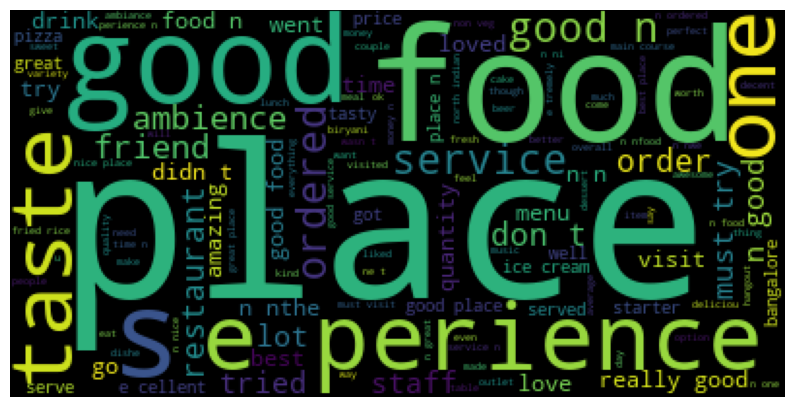

In [ ]:
plt.figure(figsize = (10,8))
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
def lowerData(text):
    return text.lower()

In [ ]:
newData['reviews_list'] = newData['reviews_list'].apply(lowerData)

In [ ]:
newData['reviews_list'] = newData['reviews_list'].apply(lambda x:x.lower())

In [ ]:
tokenizer = regextoken('[a-zA_Z]+')

In [ ]:
data = newData['reviews_list'][0]
data

'[(\'rated 5.0\', "rated\\n  had an egg chicken roll and a paneer roll... really yummy... a must visit place... it would be good if you guys can keep the shop open on sunday\'s as well.. good luck... :-)"), (\'rated 5.0\', \'rated\\n  not just the roll but the filling tastes great. i would highly recommend to others to try their rolls. owners hospitality is also good and very friendly.\'), (\'rated 4.5\', \'rated\\n  very nice place complete value for money ? highly recommend.must visit for any foodie . i would recommend the egg chicken roll . #feeltheroll\'), (\'rated 5.0\', \'rated\\n  had an amazing mouth-watering ?chicken roll?worth every bite..a must try for every foodie?a variety of rolls and sandwiches are available as well .. a budding rafflesia ?\')]'

In [ ]:
print(tokenizer.tokenize(data))

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [ ]:
reviewToken = newData['reviews_list'].apply(tokenizer.tokenize)

In [ ]:
print(reviewToken[1])

['rated', 'rated', 'n', 'this', 'little', 'cafe', 'is', 'set', 'in', 'a', 'very', 'beautiful', 'location', 'and', 'the', 'ambiance', 'was', 'too', 'good', 'nthe', 'burger', 'was', 'filled', 'with', 'taste', 'and', 'chicken', 'nthe', 'banana', 'chocolate', 'sandwich', 'was', 'a', 'variety', 'that', 'you', 'would', 'never', 'find', 'in', 'most', 'of', 'the', 'restaurants', 'in', 'bangalore', 'the', 'drinks', 'were', 'wonderful', 'and', 'had', 'lot', 'of', 'flavours', 'to', 'choose', 'from', 'nit', 'took', 'a', 'little', 'more', 'time', 'than', 'expected', 'for', 'the', 'food', 'to', 'be', 'served', 'in', 'the', 'table', 'nall', 'the', 'dishes', 'there', 'seemed', 'to', 'be', 'priced', 'moderately', 'and', 'well', 'nfood', 'nambiance', 'nservice', 'ntheir', 'chefs', 'are', 'doing', 'a', 'brilliant', 'job', 'creating', 'new', 'dishes', 'with', 'a', 'variety', 'na', 'wonderful', 'place', 'to', 'be', 'out', 'with', 'your', 'friends', 'rated', 'rated', 'n', 'a', 'cozy', 'cafe', 'near', 'silk'

In [ ]:
print(reviewToken[1])

['rated', 'rated', 'n', 'this', 'little', 'cafe', 'is', 'set', 'in', 'a', 'very', 'beautiful', 'location', 'and', 'the', 'ambiance', 'was', 'too', 'good', 'nthe', 'burger', 'was', 'filled', 'with', 'taste', 'and', 'chicken', 'nthe', 'banana', 'chocolate', 'sandwich', 'was', 'a', 'variety', 'that', 'you', 'would', 'never', 'find', 'in', 'most', 'of', 'the', 'restaurants', 'in', 'bangalore', 'the', 'drinks', 'were', 'wonderful', 'and', 'had', 'lot', 'of', 'flavours', 'to', 'choose', 'from', 'nit', 'took', 'a', 'little', 'more', 'time', 'than', 'expected', 'for', 'the', 'food', 'to', 'be', 'served', 'in', 'the', 'table', 'nall', 'the', 'dishes', 'there', 'seemed', 'to', 'be', 'priced', 'moderately', 'and', 'well', 'nfood', 'nambiance', 'nservice', 'ntheir', 'chefs', 'are', 'doing', 'a', 'brilliant', 'job', 'creating', 'new', 'dishes', 'with', 'a', 'variety', 'na', 'wonderful', 'place', 'to', 'be', 'out', 'with', 'your', 'friends', 'rated', 'rated', 'n', 'a', 'cozy', 'cafe', 'near', 'silk'

In [ ]:
stop = stopwords.words('english')

In [ ]:
stop.extend(['rated','n','nan, x'])

In [ ]:
print(reviewToken[0])

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [ ]:
review = []

for token in reviewToken[0]:
    if token not in stop:
        review.append(token)
print(review)

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia']


In [ ]:
print([token for token in reviewToken[0] if token not in stop])

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia']


In [ ]:
def removeStopwords(text):
    updatedText = [token for token in text if token not in stop]
    return updatedText

In [ ]:
reviewTokens = reviewToken.apply(removeStopwords)

In [ ]:
type(reviewTokens)

pandas.core.series.Series

In [ ]:
len(reviewTokens)

20915

In [ ]:
newData.shape

(20915, 19)

In [ ]:
allReviews = reviewTokens.astype(str).str.cat()

In [ ]:
type(allReviews)

In [ ]:
allReviews[0:500]

In [ ]:
cleanedReviews = tokenizer.tokenize(allReviews)

In [ ]:
type(cleanedReviews)

In [ ]:
print(cleanedReviews[0:200])

In [ ]:
fd = FreqDist()

In [ ]:
for word in cleanedReviews:
    fd[word] += 1


In [ ]:
fd.most_common(5)

In [ ]:
plt.figure(figsize=(15,8))
fd.plot(50)

## Bigrams

In [ ]:
bigrams = bigrams(cleanedReviews)

In [ ]:
bigrams

In [ ]:
fdBigrams = FreqDist()

In [ ]:
for bigram in bigrams:
    fdBigrams[bigram] = fdBigrams[bigram] + 1


In [ ]:
fdBigrams.most_common(50)

In [ ]:
plt.figure(figsize = (15,10))
fdBigrams.plot(50)

## Trigrams

In [ ]:
trigrams = trigrams(cleanedReviews)

In [ ]:
fdTrigrams = FreqDist()

In [ ]:
for trigram in trigrams:
    fdTrigrams[trigram] = fdTrigrams[trigram] + 1

In [ ]:
fdTrigrams.most_common(5)

In [ ]:
plt.figure(figsize=(15,8))
fdTrigrams.plot(50)

In [ ]:
newData.columns

In [ ]:
cuisines = newData[['cuisines','rating']]

In [ ]:
cuisines.head()

In [ ]:
cuisines.isnull().sum()

In [ ]:
cuisines.dropna(inplace=True)

In [ ]:
cuisines.isnull().sum()

In [ ]:
cuisines['cuisines'] = cuisines['cuisines'].apply(lambda x:x.lower())

In [ ]:
cuisinesTokens = cuisines['cuisines'].apply(tokenizer.tokenize)

In [ ]:
cuisinesTokens[0]

In [ ]:
type(cuisinesTokens[0])

In [ ]:
allCuisines = cuisinesTokens.astype(str).str.cat()

In [ ]:
cleanedCuisines = tokenizer.tokenize(allCuisines)

In [ ]:
cleanedCuisines[0]

In [ ]:
fdCuisines = FreqDist()

In [ ]:
for cuisine in cleanedCuisines:
    fdCuisines[cuisine] = fdCuisines[cuisine] + 1

In [ ]:
fdCuisines.most_common(10)

In [ ]:
fdCuisines.plot(10)

## ML Data Prep

In [ ]:
len(newData.columns)

In [ ]:
newData.columns

In [ ]:
newData.dtypes

In [ ]:
newData[['dish_liked', 'cuisines', 'reviews_list','menu_item']] = newData[['dish_liked', 'cuisines', 'reviews_list','menu_item']].astype(str)

In [ ]:
newData['text'] = newData['reviews_list'] + ' ' + newData['menu_item'] + ' ' + newData['dish_liked'] + ' ' + newData['cuisines']

In [ ]:
newData.head()

In [ ]:
textData = newData[['text', 'rating']]

In [ ]:
textData.head()

In [ ]:
textData['text'][0]

In [ ]:
textData['text'] = textData['text'].apply(lambda x:x.lower())

In [ ]:
textData.shape

In [ ]:
df = textData.sample(n=2000)

In [ ]:
df.head()

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.head()

In [ ]:
df.drop('index', axis = 1, inplace = True)

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(inplace = True)

In [ ]:
tokens = df['text'].apply(tokenizer.tokenize)

In [ ]:
tokens

In [ ]:
tokens[1]

In [ ]:
print(stop)

In [ ]:
tokens = tokens.apply(lambda x: [token for token in x if token not in stop])

In [ ]:
tokens.apply(removeStopwords)

In [ ]:
wl=WordNetLemmatizer()

In [ ]:
print(tokens[1])

In [ ]:
word = tokens[1]
print(word)

In [ ]:
lem=[]
for wd in word:
    lem.append(wl.lemmatize(wd))
lem

In [ ]:
print(lem)

In [ ]:
print([wl.lemmatize(wd)for wd in word])

In [ ]:
def lem(text):
    return [wl.lemmatize(wd) for wd in text]

In [ ]:
tokensNew = tokens.apply(lem)

In [ ]:
df.head()

In [ ]:
df['rating'].dtype

In [ ]:
le = LabelEncoder()

In [ ]:
df['rating'] = le.fit_transform(df['rating'])

In [ ]:
df['rating'].dtype

## Creating TF-IDF Model

In [ ]:
print(tokensNew[1])

In [ ]:
' '.join(tokensNew[1])

In [ ]:
tokensNew.index

In [ ]:
corpus=[]

for i in tokensNew.index:
    review =' '.join(tokens[1])
    corpus.append(review)

In [ ]:
corpus

In [ ]:
cv = TfidfVectorizer()

In [ ]:
x = cv.fit_transform(corpus).toarray()

In [ ]:
x.shape

In [ ]:
x

## Applying Logistic Regression

In [ ]:
df['rating'].value_counts()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,df['rating'],test_size = 0.3, random_state = 0, stratify = df['rating'])

In [ ]:
lr = LogisticRegression(multi_class ='multinomial')

In [ ]:
lr.fit(x_train, y_train)

In [ ]:
predictions = lr.predict(x_test)

In [ ]:
accuracy_score(predictions, y_test)

## Playing with Multiple Algorithms

In [ ]:
models = []

models.append(('Logistic Regression', LogisticRegression()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))

In [ ]:
for name, model in models:
    print(name)
    print(model)

In [ ]:
# Make predictions on validation dataset

for name, model in models:
    print(name)
    model.fit(x_train, y_train)

    # Make predictions.
    predictions = model.predict(x_test)

    # Compute the error.
    print(confusion_matrix(predictions, y_test))

    print(accuracy_score(predictions,y_test))
    print('\n')

## Model Cross Validation

In [ ]:
print(cross_val_score(lr,x,df['rating'], cv=5, scoring = 'accuracy').mean())